# Does a New Landing Page Improve Conversion Rate?

## Import Libraries

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [19]:
# data available at: https://www.kaggle.com/datasets/zhangluyuan/ab-testing/data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Explore the dataset

In [8]:
df.shape

(294478, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df.isna().sum() # Check for null values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [13]:
pd.crosstab(df['group'], df['converted'])

converted,0,1
group,,
control,129479,17723
treatment,129762,17514


In [14]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [20]:
df['user_id'].duplicated().sum() # Check for duplicates

3894

In [21]:
df.groupby(['group', 'landing_page']).size()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64

## EDA Summary

* Dataset contains user interactions from an A/B test on a landing page.

* Key columns: group, landing_page, and converted.

* Found mismatches: some users in control group got new_page and vice versa.

* Conversion metric (converted) is binary: 1 = converted, 0 = not converted.

* Duplicate user IDs detected — need to drop for clean analysis.

# Data Cleaning

In [22]:
# Remove rows where treatment doesn't match landing_page
df = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
        ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

# Remove duplicates
df.drop_duplicates(subset='user_id', inplace=True)

In [23]:
df.groupby(['group', 'landing_page']).size()

group      landing_page
control    old_page        145274
treatment  new_page        145310
dtype: int64

# Calculate Conversation Rates

In [24]:
conversion_rate = df.groupby('group')['converted'].mean()

In [25]:
conversion_rate

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

In [26]:
df.groupby('group')['converted'].agg(['count', 'sum', 'mean'])

,count,sum,mean
group,,,
control,145274,17489,0.120386
treatment,145310,17264,0.118808


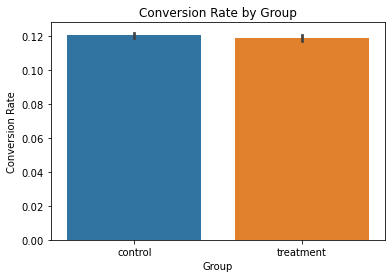

In [28]:
sns.barplot(x= 'group', y = 'converted', data = df)
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.show()

The control group had a slightly higher conversion rate (12%) compared to the treatment group (11.8%). 
Visually, the difference appears small and within the margin of error.

# Hypothesis Testing

We’ll use a **two-sample proportion z-test** since we’re comparing proportions (converted vs not) between two groups.

In [33]:
from statsmodels.stats.proportion import proportions_ztest

# Count of conversions
conversions = df.groupby('group')['converted'].sum()

# Total users in each group
n_obs = df.groupby('group')['converted'].count()

z_stat, p_value = proportions_ztest(count=conversions, nobs=n_obs, alternative='two-sided')
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

Z-Statistic: 1.3109
P-Value: 0.1899


# Interpret the Results

In [34]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis — there's a significant difference.")
else:
    print("Fail to reject the null — no significant difference detected.")


Fail to reject the null — no significant difference detected.


# Recommendation

Based on this result, we would not recommend rolling out the new landing page, as there is insufficient evidence that it improves conversions. Further testing with a larger sample size or a different variant may be more informative.